# HW4: LLM prompting for entity labeling
This notebook contains starter code for prompting an LLM API for the task of entity recognition. It has minimal text so you can easily copy it to **handin.py** when you submit.  Please read all the comments in the code as they contain important information.

In [2]:
# This code block just contains standard setup code for running in Python
import json
import string
import re
import time
from tqdm.auto import tqdm
from collections import Counter

# PyTorch imports
import torch
from torch.utils.data import DataLoader
import numpy as np
import random

# Fix the random seed(s) for reproducability
random_seed = 8942764
torch.random.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

# !pip install ipytest
# !pip install transformers
# !pip install datasets
# !pip install evaluate
# !pip install seqeval
# !pip install ratelimit

from transformers import AutoTokenizer, BertModel, DefaultDataCollator

from datasets import load_dataset

import evaluate
from ratelimit import limits

# Just a helper function for efficiently removing punctuation from a string
def strip_punct(s):  return s.translate(string.punctuation)

In [3]:
#!pip install openai
from openai import OpenAI

# Use the API key that we 
client = OpenAI(api_key='sk-3nqsPXuRAwFc5tFHNlmMhA', base_url="https://cmu.litellm.ai")
USER_STR = "user"
SYSTEM_STR = "system"
MSG_STR = "content"

In [149]:
# Here is how you can use the API to prompt the OpenAI model.
# Docs: https://platform.openai.com/docs/api-reference
messages = [
    {'role': SYSTEM_STR, MSG_STR:
     """You will be given input text containing different types of entities that you will label.
     This is the list of entity types to label: Deity, Mythological_king, Cretaceous_dinosaur, Aquatic_mammal, Aquatic_animal, Goddess.
     Label the enities by surrounding them with tags like '<Cretaceous_dinosaur> Beipiaognathus </Cretaceous_dinosaur>'."""
     }, 
     {'role': USER_STR, MSG_STR: """Text: Once paired in later myths with her Titan brother Hyperion as her husband, mild-eyed Euryphaessa, the far-shining one of the Homeric Hymn to Helios, was said to be the mother of Helios (the Sun), Selene (the Moon), and Eos (the Dawn)."""},
     {'role': SYSTEM_STR, MSG_STR: """Labels: Once paired in later myths with her Titan brother <Deity> Hyperion </Deity> as her husband, mild-eyed Euryphaessa, the far-shining one of the Homeric Hymn to Helios, was said to be the mother of Helios (the Sun), <Goddess> Selene </Goddess> (the Moon), and <Goddess> Eos </Goddess> (the Dawn)."""},
     {'role': USER_STR, MSG_STR: """Text: From her ideological conception, Taweret was closely grouped with (and is often indistinguishable from) several other protective hippopotamus goddesses: Ipet, Reret, and Hedjet.\nLabels: """}
]

# This is where you provide the final prompt that we want the model to complete to give us the answer.
# message = f"""Text: From her ideological conception, Taweret was closely grouped with (and is often indistinguishable from) several other protective hippopotamus goddesses: Ipet, Reret, and Hedjet.
# Labels: """

response = client.chat.completions.create(
    model="gpt-4o-mini",
    temperature=0.0,
    seed=random_seed,
    messages=messages
)

print(response.choices[0].message.content)

# You can also print out the usage, in number of tokens. 
# Pricing is per input/output token, listed here: https://openai.com/pricing
print(f"Usage: {response.usage.prompt_tokens} input, {response.usage.completion_tokens} output, {response.usage.total_tokens} total tokens")

From her ideological conception, <Goddess> Taweret </Goddess> was closely grouped with (and is often indistinguishable from) several other protective hippopotamus goddesses: <Goddess> Ipet </Goddess>, <Goddess> Reret </Goddess>, and <Goddess> Hedjet </Goddess>.
Usage: 307 input, 77 output, 384 total tokens


In [4]:
# Load the dataset
from datasets import Dataset, ClassLabel, Sequence

data_splits = load_dataset('json', data_files={'train': 'dinos_and_deities_train_bio.jsonl', 'dev': 'dinos_and_deities_dev_bio_sm.jsonl', 'test': 'dinos_and_deities_test_bio_nolabels.jsonl'})

# Load dicts for mapping int labels to strings, and vice versa
label_names_fname = "dinos_and_deities_train_bio.jsonl.labels"
labels_int2str = []
with open(label_names_fname) as f:
    labels_int2str = f.read().split()
print(f"Labels: {labels_int2str}")
labels_str2int = {l: i for i, l in enumerate(labels_int2str)}

# Also create a set containing the original labels, without B- and I- tags
orig_labels = set()
for label in labels_str2int.keys():
    orig_label = label[2:]
    if orig_label:
        orig_labels.add(orig_label)
print(f"Orig labels: {orig_labels}")

# data_splits.cast_column("ner_tags", Sequence(ClassLabel(names=labels_int2str)))
print(data_splits)

Labels: ['I-Aquatic_animal', 'B-Deity', 'B-Mythological_king', 'I-Mythological_king', 'I-Cretaceous_dinosaur', 'B-Aquatic_animal', 'B-Aquatic_mammal', 'I-Goddess', 'I-Deity', 'B-Cretaceous_dinosaur', 'I-Aquatic_mammal', 'B-Goddess', 'O']
Orig labels: {'Goddess', 'Mythological_king', 'Aquatic_animal', 'Deity', 'Aquatic_mammal', 'Cretaceous_dinosaur'}
DatasetDict({
    train: Dataset({
        features: ['para_index', 'title', 'doc_id', 'content', 'page_id', 'id', 'tokens', 'ner_strings', 'ner_tags'],
        num_rows: 1749
    })
    dev: Dataset({
        features: ['para_index', 'title', 'doc_id', 'content', 'page_id', 'id', 'tokens', 'ner_strings', 'ner_tags'],
        num_rows: 150
    })
    test: Dataset({
        features: ['para_index', 'title', 'doc_id', 'content', 'page_id', 'id', 'tokens', 'ner_strings', 'ner_tags'],
        num_rows: 303
    })
})


In [5]:
# Let's inspect a single example
dev_example = data_splits['dev'][5]

#print(json.dumps(dev_example, indent=4))
data_splits['dev'][2].keys()

dict_keys(['para_index', 'title', 'doc_id', 'content', 'page_id', 'id', 'tokens', 'ner_strings', 'ner_tags'])

In [6]:
# Ok, now let's make the prompting a bit more programmatic. First, implement a function that takes an example from
# the dataset, and converts it into a message for the model using the format we specified above. 
# You might want to use the Python string "format" function to make this a bit easier, especially since 
# You will be experimenting with different prompts later.
#
def get_message(example):

    tokens = example['tokens']
        
    # Join tokens back into a text 
    formatted_text = " ".join(tokens)
    return formatted_text

In [7]:
#Debugging step: Please ignore
example_dict = get_message(dev_example)
print(example_dict)

Hadingus was one of the earliest legendary Danish kings according to Saxo Grammaticus' Gesta Danorum, where he has a detailed biography. Georges Dumézil and others have argued that Hadingus was partially modelled on the god Njörðr.


In [8]:
# Next we're going to implement a function to return the chat_history, but in order to do that we first need
# to be able to convert labeled examples from the dataset into a format that makes more sense for the model,
# in this case the HTML-style format we specified in the example. That's the task for this function: take
# an example from the dataset as input, and return a string that has tagged the text with labels in the given
# HTML-style format.
# 
# TODO: implement this.
def convert_bio_to_prompt(example):
    """
    Converts an example in BIO format into an HTML-style labeled string.
"""
    tokens = example['tokens']
    ner_strings = example['ner_strings']
    
    # Initialize variables
    labeled_text = []
    current_tag = None

    # Iterate through tokens and their tags
    for token, tag in zip(tokens, ner_strings):
        if tag.startswith("B-"):  # Beginning of a new entity
            if current_tag:  # Close the previous tag if one is open
                labeled_text.append(f"</{current_tag}>")
            current_tag = tag.split("-")[1]
            labeled_text.append(f"<{current_tag}> {token}")
        elif tag.startswith("I-") and current_tag == tag.split("-")[1]:  # Inside the same entity
            labeled_text.append(f" {token}")
        else:  # Outside of any entity
            if current_tag:  # Close the previous tag if one is open
                labeled_text.append(f"</{current_tag}>")
                current_tag = None
            labeled_text.append(token)

    # Close any remaining open tag
    if current_tag:
        labeled_text.append(f"</{current_tag}>")

    # Join the labeled text into a single string
    return " ".join(labeled_text)

In [9]:
example_html = convert_bio_to_prompt(dev_example)
print(example_html)

<Mythological_king> Hadingus </Mythological_king> was one of the earliest legendary Danish kings according to Saxo Grammaticus' Gesta Danorum, where he has a detailed biography. Georges Dumézil and others have argued that <Mythological_king> Hadingus </Mythological_king> was partially modelled on the god <Mythological_king> Njörðr. </Mythological_king>


In [10]:
def get_chat_history(shots, dataset, entity_types_list, convert_bio_to_prompt_fn):

    chat_history = []

    # Add the system message 
    system_message = {
        "role": "system",
        "content": (
            f"You will be given input text containing different types of entities that you will label. "
            f"This is the list of entity types to label: {', '.join(entity_types_list)}. "
            f"Label the entities by surrounding them with tags like '<Cretaceous_dinosaur> Beipiaognathus </Cretaceous_dinosaur>'."
        )
    }
    chat_history.append(system_message)

    shots = min(shots, len(dataset))
    for i in range(shots):
        example = dataset[i]
        labeled_text = convert_bio_to_prompt_fn(example)

        # Create user and assistant messages
        user_message = {
            "role": "user",
            "content": f"Text: {' '.join(example['tokens'])}"
        }
        assistant_message = {
            "role": "assistant",
            "content": f"Labels: {labeled_text}"
        }

        # Appending the user and assistant messages
        chat_history.extend([user_message, assistant_message])

    return chat_history


In [11]:
#Test code for number of shots
for i in range(3):
    example = data_splits['train'][i]
    labeled_text = convert_bio_to_prompt(example)
    print(labeled_text)
    content = example['content']
    print(content)
    print(example['ner_strings'])
    print('****************************************')

<Cretaceous_dinosaur> Mahakala </Cretaceous_dinosaur> is based on IGM 100/1033, a partial skeleton including skull bones, vertebrae, limb bones, and portions of the pelvis and shoulder girdle. Although this individual was small, comparable in size to Archaeopteryx, <Cretaceous_dinosaur> Caudipteryx, </Cretaceous_dinosaur> and Mei, it was close to adulthood. This genus can be distinguished from other paravians (dromaeosaurids, troodontids, and birds) by details of the ulna, thighbone, ilium, and tail vertebrae. Like Archaeopteryx and derived dromaeosaurids, but unlike basal troodontids and other dromaeosaurids, the middle (third) metatarsal was not compressed, suggesting that the uncompressed version was the basal version. It had a typical dromaeosaurid form of the second toe, with an expanded claw.
Mahakala is based on IGM 100/1033, a partial skeleton including skull bones, vertebrae, limb bones, and portions of the pelvis and shoulder girdle. Although this individual was small, compar

In [ ]:
# Final code for sending to GPT 
num_shots = 2

chat_history = get_chat_history(num_shots, data_splits['train'], orig_labels, convert_bio_to_prompt)
message = {'role': USER_STR, MSG_STR: get_message(dev_example)}
chat_history.append(message)

response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    temperature=0.0,
    seed=random_seed,
    messages=chat_history
)

print(response.choices[0].message.content)

# # Inspect chat history for debugging
# print(json.dumps(chat_history, indent=4))

Labels: <Mythological_king> Hadingus </Mythological_king> was one of the earliest legendary Danish kings according to Saxo Grammaticus' Gesta Danorum, where he has a detailed biography. Georges Dumézil and others have argued that <Deity> Hadingus </Deity> was partially modelled on the god Njörðr.


In [31]:
# Now let's wrap that call in a function that takes shots and an example, calls the API and returns the response.
def call_api_openai(shots, example):
    success = False
    while not success:
        try:
            chat_history = get_shuffled_chat_history(shots, data_splits['train'], orig_labels, convert_bio_to_prompt)
            message = {'role': USER_STR, 'content': get_message(example)}
            chat_history.append(message)
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                temperature=0.0,
                messages=chat_history
            )
            success = 1
        except Exception as err:
            tqdm.write(f"Caught exception: {err}")
    return response.choices[0].message.content 

In [13]:
# Now we want to be able to evaluate the model, in order to compare it to e.g. the fine-tuned BERT model.
# In order to do this, we need to write the reverse of the convert_bio_to_prompt function, so that we can
# convert in the other direction, from the generated response in prompt format, back to bio for evaluation
# using seqeval.
#
# The input to this function is the string response from the model, and the output should be a list of 
# text BIO labels corresponding to the labeling implied by the tagged output produced by the model, as 
# well as the list of tokens (since the generative model could return something different than we gave it,
# and we need to handle that somehow in the eval).
#
import string

def convert_response_to_bio(response):

        # Remove 'Labels:'
    if response.startswith('Labels:'):
        response = response[len('Labels:'):].strip()
    
    tokens = []
    bio_labels = []

    # Regular expression to match tags and plain text
    tag_pattern = re.compile(r"(</?[\w\-]+>)|([^<>]+)")  # Matches <tag>, </tag>, and plain text

    current_label = "O"  # Start with "O" (outside any entity)
    inside_entity = False  # Track whether we are inside an entity tag

    for match in tag_pattern.finditer(response):
        tag_or_text = match.group()

        if tag_or_text.startswith("</"):  # Closing tag
            current_label = "O"
            inside_entity = False
        elif tag_or_text.startswith("<"):  # Opening tag
            current_label = tag_or_text[1:-1]  # Extract tag name without <>
            inside_entity = True
        else:
            # Process plain text
            for i, token in enumerate(tag_or_text.split()):
                tokens.append(token)

                if inside_entity:
                    #bio_labels.append(current_label)
                    if i == 0:
                        bio_labels.append(f"B-{current_label}")  # Start of an entity
                    else:
                        bio_labels.append(f"I-{current_label}")  # Continuation of the same entity
                else:
                    bio_labels.append("O")  # Outside any entity

    punctuations = set(string.punctuation)
    merged_tokens = []
    merged_bio_labels = []

    for token, label in zip(tokens, bio_labels):
        if token in punctuations and merged_tokens:
            merged_tokens[-1] += token
        else:
            merged_tokens.append(token)
            merged_bio_labels.append(label)

    return merged_bio_labels, merged_tokens

In [14]:
def test_convert_html_to_bio():
    html_str = 'From <Goddess> her</Goddess> ideological conception, <Goddess> the deity Taweret </Goddess> was closely grouped with (and is often indistinguishable from) several other protective <Aquatic_mammal>hippopotamus</Aquatic_mammal> <Goddess>goddesses </Goddess>: <Goddess> Ipet ("the Nurse")</Goddess>, <Goddess>Reret ("the Sow") </Goddess>, and <Goddess>Hedjet ("the White One")</Goddess>.'
    labels, text = convert_response_to_bio(html_str)
    true_labels = ['O', 'B-Goddess', 'O', 'O', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Aquatic_mammal', 'B-Goddess', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'O', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'I-Goddess']
    true_text = ['From', 'her', 'ideological', 'conception,', 'the', 'deity', 'Taweret', 'was', 'closely', 'grouped', 'with', '(and', 'is', 'often', 'indistinguishable', 'from)', 'several', 'other', 'protective', 'hippopotamus', 'goddesses:', 'Ipet', '("the', 'Nurse"),', 'Reret', '("the', 'Sow"),', 'and', 'Hedjet', '("the', 'White', 'One").']
    print(labels)
    print(true_labels)
test_convert_html_to_bio()

['O', 'B-Goddess', 'O', 'O', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Aquatic_mammal', 'B-Goddess', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'O', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'I-Goddess']
['O', 'B-Goddess', 'O', 'O', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Aquatic_mammal', 'B-Goddess', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'O', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'I-Goddess']


In [15]:
def test_convert_html_to_bio_labels():
    html_str = 'Labels: From <Goddess> her</Goddess> ideological conception, <Goddess> the deity Taweret </Goddess> was closely grouped with (and is often indistinguishable from) several other protective <Aquatic_mammal>hippopotamus</Aquatic_mammal> <Goddess>goddesses </Goddess>: <Goddess> Ipet ("the Nurse")</Goddess>, <Goddess>Reret ("the Sow") </Goddess>, and <Goddess>Hedjet ("the White One")</Goddess>.'
    labels, text = convert_response_to_bio(html_str)
    true_labels = ['O', 'B-Goddess', 'O', 'O', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Aquatic_mammal', 'B-Goddess', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'O', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'I-Goddess']
    true_text = ['From', 'her', 'ideological', 'conception,', 'the', 'deity', 'Taweret', 'was', 'closely', 'grouped', 'with', '(and', 'is', 'often', 'indistinguishable', 'from)', 'several', 'other', 'protective', 'hippopotamus', 'goddesses:', 'Ipet', '("the', 'Nurse"),', 'Reret', '("the', 'Sow"),', 'and', 'Hedjet', '("the', 'White', 'One").']
    print(text)
    print(true_text)
test_convert_html_to_bio_labels()

['From', 'her', 'ideological', 'conception,', 'the', 'deity', 'Taweret', 'was', 'closely', 'grouped', 'with', '(and', 'is', 'often', 'indistinguishable', 'from)', 'several', 'other', 'protective', 'hippopotamus', 'goddesses:', 'Ipet', '("the', 'Nurse"),', 'Reret', '("the', 'Sow"),', 'and', 'Hedjet', '("the', 'White', 'One").']
['From', 'her', 'ideological', 'conception,', 'the', 'deity', 'Taweret', 'was', 'closely', 'grouped', 'with', '(and', 'is', 'often', 'indistinguishable', 'from)', 'several', 'other', 'protective', 'hippopotamus', 'goddesses:', 'Ipet', '("the', 'Nurse"),', 'Reret', '("the', 'Sow"),', 'and', 'Hedjet', '("the', 'White', 'One").']


In [17]:
# Here's a test example you can use to validate/debug your code (note that this was constructed to simulate various
# spacing/tokenization scenarios and does not necessarily reflect "correct" labeling wrt the training data):
import ipytest
ipytest.autoconfig()
def test_convert_html_to_bio():
    html_str = 'From <Goddess> her</Goddess> ideological conception, <Goddess> the deity Taweret </Goddess> was closely grouped with (and is often indistinguishable from) several other protective <Aquatic_mammal>hippopotamus</Aquatic_mammal> <Goddess>goddesses </Goddess>: <Goddess> Ipet ("the Nurse")</Goddess>, <Goddess>Reret ("the Sow") </Goddess>, and <Goddess>Hedjet ("the White One")</Goddess>.'
    labels, text = convert_response_to_bio(html_str)
    true_labels = ['O', 'B-Goddess', 'O', 'O', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Aquatic_mammal', 'B-Goddess', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'O', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'I-Goddess']
    true_text = ['From', 'her', 'ideological', 'conception,', 'the', 'deity', 'Taweret', 'was', 'closely', 'grouped', 'with', '(and', 'is', 'often', 'indistinguishable', 'from)', 'several', 'other', 'protective', 'hippopotamus', 'goddesses:', 'Ipet', '("the', 'Nurse"),', 'Reret', '("the', 'Sow"),', 'and', 'Hedjet', '("the', 'White', 'One").']
    #print(labels)
    print(text)
    # assert labels == true_labels
    assert text == true_text

def test_convert_html_to_bio_labels():
    html_str = 'Labels: From <Goddess> her</Goddess> ideological conception, <Goddess> the deity Taweret </Goddess> was closely grouped with (and is often indistinguishable from) several other protective <Aquatic_mammal>hippopotamus</Aquatic_mammal> <Goddess>goddesses </Goddess>: <Goddess> Ipet ("the Nurse")</Goddess>, <Goddess>Reret ("the Sow") </Goddess>, and <Goddess>Hedjet ("the White One")</Goddess>.'
    labels, text = convert_response_to_bio(html_str)
    true_labels = ['O', 'B-Goddess', 'O', 'O', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Aquatic_mammal', 'B-Goddess', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'O', 'B-Goddess', 'I-Goddess', 'I-Goddess', 'I-Goddess']
    true_text = ['From', 'her', 'ideological', 'conception,', 'the', 'deity', 'Taweret', 'was', 'closely', 'grouped', 'with', '(and', 'is', 'often', 'indistinguishable', 'from)', 'several', 'other', 'protective', 'hippopotamus', 'goddesses:', 'Ipet', '("the', 'Nurse"),', 'Reret', '("the', 'Sow"),', 'and', 'Hedjet', '("the', 'White', 'One").']
    #print(labels)
    print(text)
    # assert labels == true_labels
    assert text == true_text

ipytest.run('-vv')  # '-vv' for increased verbosity

======================================= test session starts =======================================
platform win32 -- Python 3.9.7, pytest-8.3.4, pluggy-1.5.0 -- c:\Users\jayan\AppData\Local\Programs\Python\Python39\python.exe
cachedir: .pytest_cache
rootdir: d:\Fall 24\NLP\HW4 4
plugins: anyio-4.7.0
collecting ... collected 2 items

t_0b4059bcea86490b9e935cf76c89a97a.py::test_convert_html_to_bio PASSED                       [ 50%]
t_0b4059bcea86490b9e935cf76c89a97a.py::test_convert_html_to_bio_labels PASSED                [100%]

======================================== warnings summary =========================================
c:\Users\jayan\AppData\Local\Programs\Python\Python39\lib\site-packages\_pytest\config\__init__.py:1277
  c:\Users\jayan\AppData\Local\Programs\Python\Python39\lib\site-packages\_pytest\config\__init__.py:1277: PytestAssertRewriteWarning: Module already imported so cannot be rewritten: anyio
    self._mark_plugins_for_rewrite(hook)

-- Docs: https://docs.pytest

<ExitCode.OK: 0>

In [18]:
# Now we can put all of the above together to evaluate!
metric = evaluate.load("seqeval")

def run_eval(dataset, shots):

  for example in tqdm(dataset, total=len(dataset), desc="Evaluating", position=tqdm._get_free_pos()):

      # String list of labels (BIO)
      true_labels = [labels_int2str[l] for l in example['ner_tags']]
      example_tokens = example['tokens']

      response_text = call_api_openai(shots, example)

      # String list of predicted labels (BIO)
      predictions, generated_tokens = convert_response_to_bio(response_text)

      # Handle case where the generated text doesn't align with the input text.
      # Basically, we'll eval everything up to where the two strings start to diverge.
      # We relax this slightly by ignoring punctuation (sometimes we lose a paren or something, 
      # but that's not catastrophic for eval/tokenization).
      # Just predict 'O' for anything following mismatch.
      matching_elements = [strip_punct(i) == strip_punct(j) for i, j in zip(example_tokens, generated_tokens)]

      if False in matching_elements:
         last_matching_idx = matching_elements.index(False)
      else:
         last_matching_idx = min(len(generated_tokens), len(example_tokens))

      predictions = predictions[:last_matching_idx] + ['O']*(len(example_tokens)-last_matching_idx)
      metric.add(predictions=predictions, references=true_labels)
  
  return metric.compute()

In [23]:
# Run the eval on the dev set
dev_examples_to_take = 0

dev_set = data_splits['dev']
if dev_examples_to_take > 0:
    dev_set = data_splits['dev'].select(range(dev_examples_to_take))

for num_shots in [1]:
    print(f"shots: {num_shots}")
    result = run_eval(dev_set, shots=num_shots)
    print(result)

shots: 1


Evaluating:   0%|          | 0/150 [00:00<?, ?it/s]

{'Aquatic_animal': {'precision': 0.2, 'recall': 0.08064516129032258, 'f1': 0.11494252873563218, 'number': 62}, 'Aquatic_insect': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0}, 'Aquatic_mammal': {'precision': 0.45454545454545453, 'recall': 0.14285714285714285, 'f1': 0.21739130434782608, 'number': 35}, 'Cretaceous_dinosaur': {'precision': 0.5, 'recall': 0.4722222222222222, 'f1': 0.4857142857142857, 'number': 36}, 'Deity': {'precision': 0.22119815668202766, 'recall': 0.41739130434782606, 'f1': 0.28915662650602414, 'number': 115}, 'Goddess': {'precision': 0.08571428571428572, 'recall': 0.04411764705882353, 'f1': 0.05825242718446602, 'number': 68}, 'Mythological_king': {'precision': 0.09375, 'recall': 0.42857142857142855, 'f1': 0.15384615384615383, 'number': 14}, 'Titan': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0}, 'overall_precision': 0.21649484536082475, 'overall_recall': 0.2545454545454545, 'overall_f1': 0.233983286908078, 'overall_accuracy': 0.9502987902638099

## Output for Evaluation

In the following cells, run your trained model on the test data, and produce a list of lists of tags, with one list per sentence, e.g. 

```
[
    [
        "B-Aquatic_animal",
        "I-Aquatic_animal",
        "I-Aquatic_animal",
...
        "O",
        "O",
        "B-Aquatic_animal",
        "I-Aquatic_animal"
    ],
    [...]
]
```

Serialize your predictions into a file named `test_predictions_llm_baseline.json` for your initial attempt at an LLM tagger. Your expected f1 on the wittheld test set should be 0.2. Then, serialize your predictions for any further experiments into a file called `test_predictions_llm_experiment.json`. This file will reflect the results that you were able to achieve with more prompt engineering.

In [34]:
def run_eval_save_predictions(dataset, shots, output_filename="test_predictions_llm_experiment.json"):

    all_predictions = []

    for example in tqdm(dataset, total=len(dataset), desc="Evaluating", position=tqdm._get_free_pos()):
        # String list of labels (BIO)
        true_labels = [labels_int2str[l] for l in example['ner_tags']]
        example_tokens = example['tokens']

        response_text = call_api_openai(shots, example)

        # String list of predicted labels (BIO)
        predictions, generated_tokens = convert_response_to_bio(response_text)

        # Handle case where the generated text doesn't align with the input text
        matching_elements = [strip_punct(i) == strip_punct(j) for i, j in zip(example_tokens, generated_tokens)]

        if False in matching_elements:
            last_matching_idx = matching_elements.index(False)
        else:
            last_matching_idx = min(len(generated_tokens), len(example_tokens))

        # Adjust predictions for mismatch
        predictions = predictions[:last_matching_idx] + ['O'] * (len(example_tokens) - last_matching_idx)

        # Save predictions for this sentence
        all_predictions.append(predictions)

    # Write predictions to the JSON file
    with open(output_filename, "w") as f:
        json.dump(all_predictions, f, indent=4)

    print(f"Predictions saved to {output_filename}")


In [35]:
run_eval_save_predictions(data_splits['test'], 2)

Evaluating:   0%|          | 0/303 [00:00<?, ?it/s]

Predictions saved to test_predictions_llm_experiment.json


## Experimenting running a changed LLM (Part-2)

In [245]:
''' The following functions outputs a dictionary which ounts the occurrences of unique NER labels in the first 'n' examples of the training data,
    excluding the 'O' label.'''

def count_ner_labels(dataset, n):

    label_counter = Counter()
    
    for i in range(n):
        # Gather the unique labels in the current example
        unique_tags = set(dataset[i]['ner_strings'])
        
        # Exclude the 'O' label
        unique_tags.discard('O')
        
        # Count each label
        for unique_label in unique_tags:
            label_counter[unique_label] += 1

    return dict(label_counter)


In [259]:
count_ner_labels(data_splits['train'], 20)

{'B-Cretaceous_dinosaur': 2,
 'B-Deity': 4,
 'B-Goddess': 6,
 'I-Goddess': 3,
 'B-Aquatic_animal': 8,
 'I-Aquatic_animal': 7,
 'I-Deity': 1,
 'B-Mythological_king': 1}

In [254]:
""" This code snippet iterates though the result of the validation dataset results, to display the count and F1 score for each label. """

for tag in result.keys():
    if tag != 'overall':
        print(f"{tag}; Count: {result[tag]['number']}, F1 Score: {result[tag]['f1']} ")

Aquatic_animal; Count: 62, F1 Score: 0.21782178217821782 
Aquatic_mammal; Count: 35, F1 Score: 0.043478260869565216 
Aquatic_plant; Count: 0, F1 Score: 0.0 
Cretaceous_dinosaur; Count: 36, F1 Score: 0.3466666666666667 
Deity; Count: 115, F1 Score: 0.34449760765550236 
Goddess; Count: 68, F1 Score: 0.2692307692307692 
Mythological_king; Count: 14, F1 Score: 0.08888888888888889 


IndexError: invalid index to scalar variable.

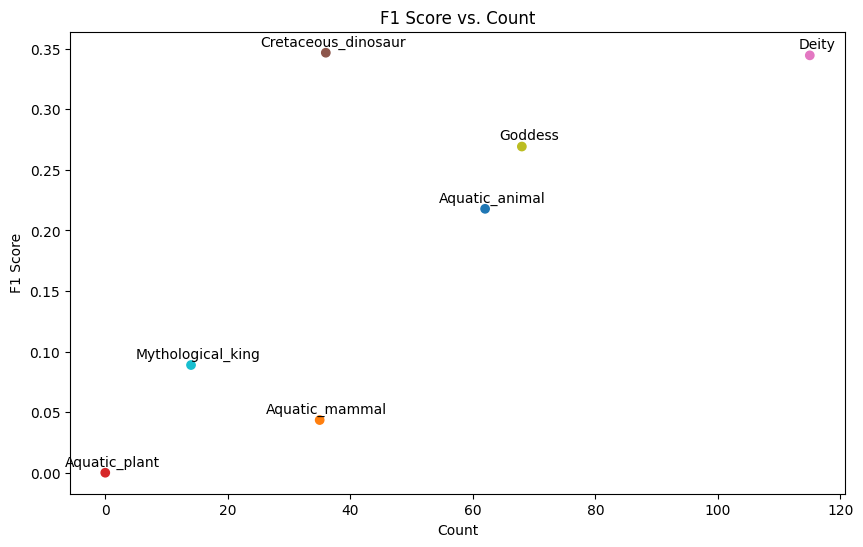

In [ ]:
#Plotting a scatter plot to visualise the data of the validation run, plotting F1 score vs count for each variable
data_run1 = [
    ("Aquatic_animal", 62, 0.21782178217821782),
    ("Aquatic_mammal", 35, 0.043478260869565216),
    ("Aquatic_plant", 0, 0.0),
    ("Cretaceous_dinosaur", 36, 0.3466666666666667),
    ("Deity", 115, 0.34449760765550236),
    ("Goddess", 68, 0.2692307692307692),
    ("Mythological_king", 14, 0.08888888888888889),
]

data_run2 = {'Aquatic_animal': {'precision': 0.3076923076923077, 'recall': 0.12903225806451613, 'f1': 0.18181818181818182, 'number': 62}, 'Aquatic_insect': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0}, 'Aquatic_mammal': {'precision': 0.18181818181818182, 'recall': 0.05714285714285714, 'f1': 0.08695652173913043, 'number': 35}, 'Cretaceous_dinosaur': {'precision': 0.5416666666666666, 'recall': 0.7222222222222222, 'f1': 0.619047619047619, 'number': 36}, 'Deity': {'precision': 0.29850746268656714, 'recall': 0.5217391304347826, 'f1': 0.37974683544303794, 'number': 115}, 'Goddess': {'precision': 0.2564102564102564, 'recall': 0.14705882352941177, 'f1': 0.18691588785046728, 'number': 68}, 'Mythological_king': {'precision': 0.12195121951219512, 'recall': 0.35714285714285715, 'f1': 0.18181818181818182, 'number': 14}

# Extract data for plotting
tags = [row[0] for row in data]
counts = [row[1] for row in data]
f1_scores = [row[2] for row in data]

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(counts, f1_scores, c=range(len(tags)), cmap='tab10', label=tags)

# Add labels to each point
for i, label in enumerate(tags):
    plt.annotate(label, (counts[i], f1_scores[i]), textcoords="offset points", xytext=(5, 5), ha='center')

# Add axis labels and title
plt.xlabel("Count")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Count")

# Show the plot
plt.show()


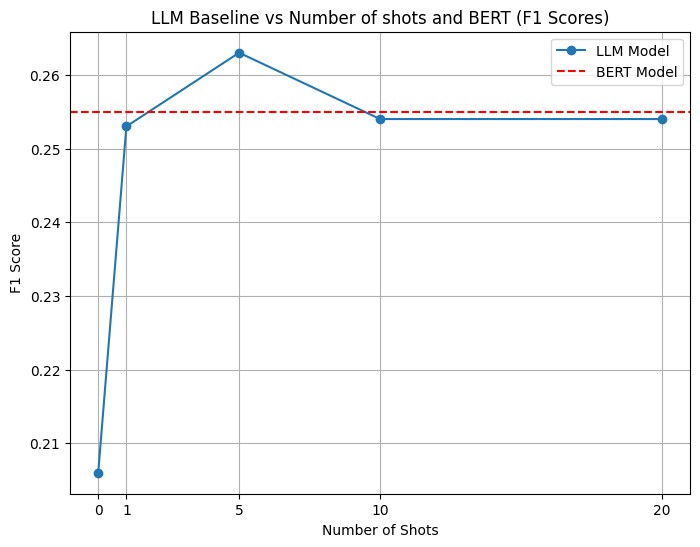

In [ ]:
# Add the BERT model F1 score as a dotted line
bert_f1 = 0.255

plt.figure(figsize=(8, 6))
plt.plot(shots, f1_scores, marker='o', label="LLM Model")
plt.axhline(y=bert_f1, color='r', linestyle='--', label="BERT Model")

# Adding labels and title
plt.title("LLM Baseline vs Number of shots and BERT (F1 Scores)")
plt.xlabel("Number of Shots")
plt.ylabel("F1 Score")
plt.xticks(shots)
plt.legend()
plt.grid(True)

# Display the graph
plt.show()


In [32]:
def get_shuffled_chat_history(shots, dataset, entity_types_list, convert_bio_to_prompt_fn):
    """
    Prepare the chat history with a balanced and diverse selection of examples.
    """

    chat_history = []

    # Add the system message 
    system_message = {
        "role": "system",
        "content": (
            f"You will be given input text containing different types of entities that you will label. "
            f"This is the list of entity types to label: {', '.join(entity_types_list)}. "
            f"Label the entities by surrounding them with tags like '<Cretaceous_dinosaur> Beipiaognathus </Cretaceous_dinosaur>'."
        )
    }
    chat_history.append(system_message)

    # Count label occurrences
    label_counts = {}
    for example in dataset:
        unique_labels = set(tag[2:] for tag in example["ner_strings"] if tag != "O")
        for label in unique_labels:
            label_counts[label] = label_counts.get(label, 0) + 1

    # Shuffle dataset to balance label occurrences
    shuffled_dataset = []
    for label in label_counts:
        label_examples = [ex for ex in dataset if any(label in tag for tag in ex["ner_strings"])]
        random.shuffle(label_examples)
        shuffled_dataset.extend(label_examples)

    # Ensure we don't exceed the total dataset length
    shuffled_dataset = shuffled_dataset[:len(dataset)]

    # Select the shots
    shots = min(shots, len(shuffled_dataset))
    for i in range(shots):
        example = shuffled_dataset[i]
        labeled_text = convert_bio_to_prompt_fn(example)

        # Create user and assistant messages
        user_message = {
            "role": "user",
            "content": f"Text: {' '.join(example['tokens'])}"
        }
        assistant_message = {
            "role": "assistant",
            "content": f"Labels: {labeled_text}"
        }

        # Appending the user and assistant messages
        chat_history.extend([user_message, assistant_message])

    return chat_history


In [262]:
num_shots = 10

chat_history = get_shuffled_chat_history(num_shots, data_splits['train'], orig_labels, convert_bio_to_prompt)
message = {'role': USER_STR, MSG_STR: get_message(dev_example)}
chat_history.append(message)

# response = client.chat.completions.create(
#     model="gpt-3.5-turbo",
#     temperature=0.0,
#     seed=random_seed,
#     messages=chat_history
# )

# print(response.choices[0].message.content)

# Inspect chat history for debugging
print(json.dumps(chat_history, indent=4))

[
    {
        "role": "system",
        "content": "You will be given input text containing different types of entities that you will label. This is the list of entity types to label: Cretaceous_dinosaur, Aquatic_mammal, Mythological_king, Goddess, Deity, Aquatic_animal. Label the entities by surrounding them with tags like '<Cretaceous_dinosaur> Beipiaognathus </Cretaceous_dinosaur>'."
    },
    {
        "role": "user",
        "content": "Text: As previously mentioned, the Huincul Formation is thought to represent an arid environment with ephemeral or seasonal streams. The age of this formation is estimated at 97 to 93.5 Mya. The dinosaur record is considered sparse here. Mapusaurus shared its environment with sauropods Argentinosaurus (one of the largest sauropods, if not the largest), and Cathartesaura. Abelisauroid theropods Skorpiovenator and Ilokelesia also lived in the region."
    },
    {
        "role": "assistant",
        "content": "Labels: As previously mentioned, th

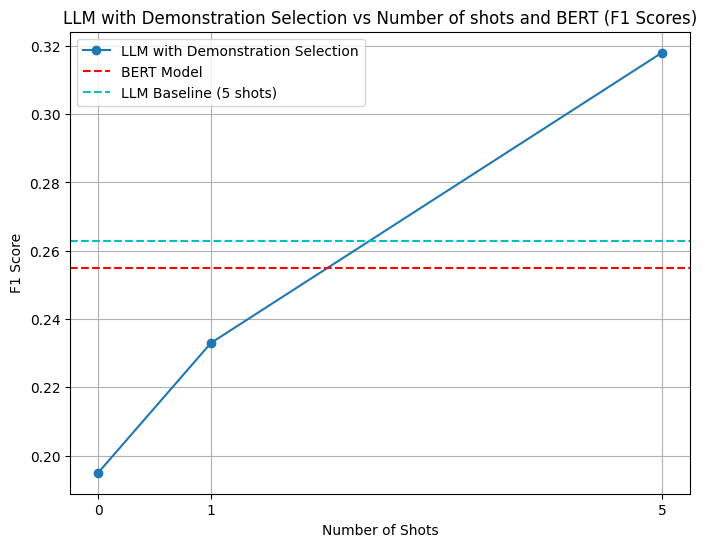

In [ ]:
import matplotlib.pyplot as plt
bert_f1 = 0.255
shots=[0,1,5]
f1_scores =[0.195, 0.233, 0.318]
llm_base =0.263
plt.figure(figsize=(8, 6))
plt.plot(shots, f1_scores, marker='o', label="LLM with Demonstration Selection")
plt.plot(shots, f1_scores, marker='o', label="LLM with Demonstration Selection")
plt.axhline(y=bert_f1, color='r', linestyle='--', label="BERT Model")
plt.axhline(y=llm_base, color='c', linestyle='--', label="LLM Baseline (5 shots)")

# Adding labels and title
plt.title("LLM with Demonstration Selection vs Number of shots and BERT (F1 Scores)")
plt.xlabel("Number of Shots")
plt.ylabel("F1 Score")
plt.xticks(shots)
plt.legend()
plt.grid(True)

# Display the graph
plt.show()


In [28]:
#import numpy as np

# Data
data = [9,11,6,7,4]

# Calculate standard deviation
std_dev = np.std(data)
std_dev


2.4166091947189146

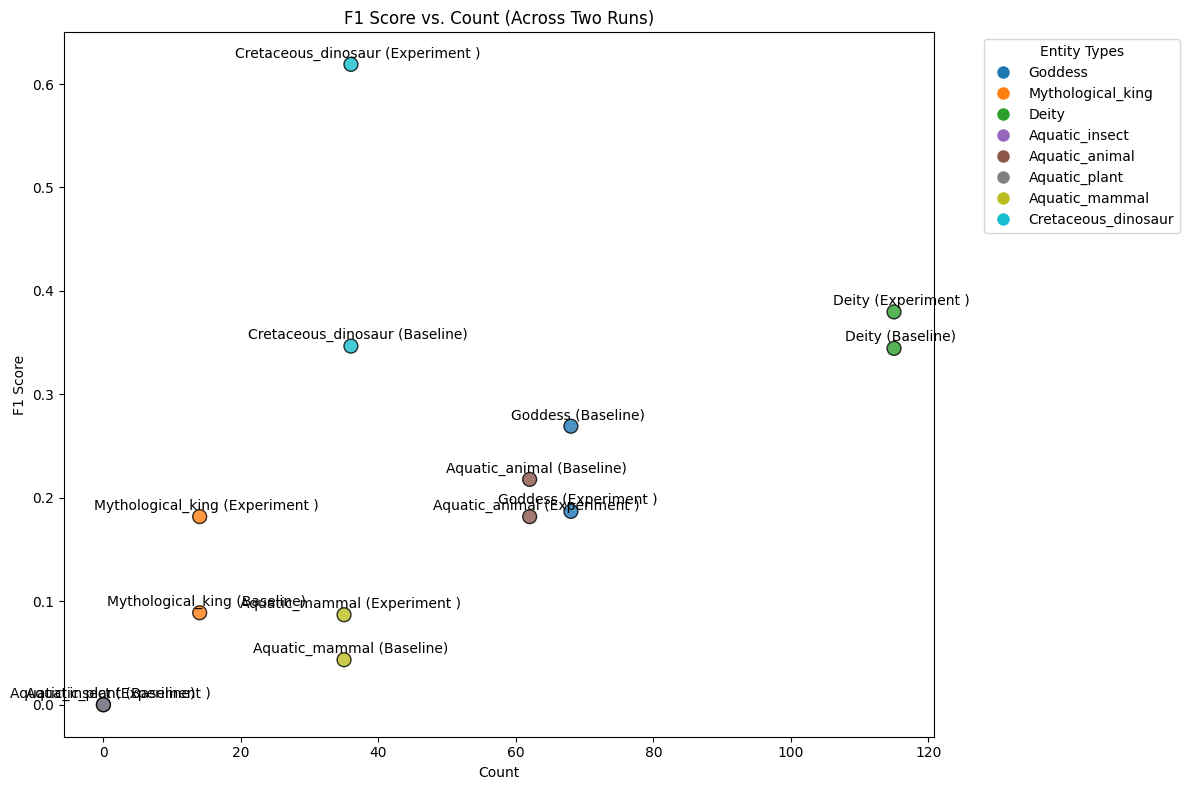

In [ ]:
# Data for the first run
data_run1 = [
    ("Aquatic_animal", 62, 0.21782178217821782),
    ("Aquatic_mammal", 35, 0.043478260869565216),
    ("Aquatic_plant", 0, 0.0),
    ("Cretaceous_dinosaur", 36, 0.3466666666666667),
    ("Deity", 115, 0.34449760765550236),
    ("Goddess", 68, 0.2692307692307692),
    ("Mythological_king", 14, 0.08888888888888889),
]

# Data for the second run
data_run2 = {
    "Aquatic_animal": {"number": 62, "f1": 0.18181818181818182},
    "Aquatic_insect": {"number": 0, "f1": 0.0},
    "Aquatic_mammal": {"number": 35, "f1": 0.08695652173913043},
    "Cretaceous_dinosaur": {"number": 36, "f1": 0.619047619047619},
    "Deity": {"number": 115, "f1": 0.37974683544303794},
    "Goddess": {"number": 68, "f1": 0.18691588785046728},
    "Mythological_king": {"number": 14, "f1": 0.18181818181818182},
}


labels = list({row[0] for row in data_run1}.union(data_run2.keys()))
data_points = []
for label in labels:
    run1_data = next((row for row in data_run1 if row[0] == label), None)
    run2_data = data_run2.get(label, {"number": None, "f1": None})
    
    if run1_data:
        data_points.append((label, run1_data[1], run1_data[2], "Baseline"))
    if run2_data["number"] is not None:
        data_points.append((label, run2_data["number"], run2_data["f1"], "Experiment "))

x = [point[1] for point in data_points]
y = [point[2] for point in data_points]
colors = [labels.index(point[0]) for point in data_points]
runs = [point[3] for point in data_points]

plt.figure(figsize=(12, 8))
scatter = plt.scatter(x, y, c=colors, cmap='tab10', s=100, edgecolor='k', alpha=0.8)


for i, point in enumerate(data_points):
    plt.annotate(f"{point[0]} ({point[3]})", (x[i], y[i]), textcoords="offset points", xytext=(5, 5), ha='center')


plt.xlabel("Count")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Count (Across Two Runs)")
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(c)), markersize=10) for c in range(len(labels))]
plt.legend(handles, labels, title="Entity Types", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
